In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score
import json
import csv

In [2]:
N_WAVELENGTH = 228
LOD_HISTAMINE = 100
NAME_COLUMNS_HISTAMINE ='Histamine\n(mg/kg)'

In [3]:
df_train = pd.read_csv("data_NIRS/merged_db_Histamine.csv")

columns_wl = {}
for i, col in enumerate(df_train.columns[-N_WAVELENGTH:]):
    columns_wl[col] = str(i+1)
    
df_train.rename(columns=columns_wl, inplace=True)
df_train.head()

,Mã mẫu NIRS,Nhóm đo,Chỉ tiêu đo,Loại cá,Địa điểm lấy mẫu,STT mẫu cá,Vị trí đo,Lần lặp,Phương pháp đo,Ngày đo,...,219,220,221,222,223,224,225,226,227,228
0,2231001a1,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",1,Hadamard 1,13/11/21,...,1.260815,1.255657,1.276434,1.322620,1.304198,1.285766,1.306818,1.267184,1.411523,1.352860
1,2231001a2,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",2,Hadamard 1,13/11/21,...,1.213489,1.231890,1.313393,1.314022,1.395009,1.452664,1.381067,1.484528,1.253933,1.233967
2,2231001a3,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",3,Hadamard 1,13/11/21,...,1.219571,1.272744,1.342526,1.342042,1.482628,1.419886,1.392945,1.367681,1.254773,1.268085
3,2231001a4,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",4,Hadamard 1,13/11/21,...,1.233272,1.338020,1.459565,1.392858,1.357045,1.388063,1.224139,1.248838,1.209269,1.289710
4,2231001a5,Đà Nẵng,Histamine,Ngừ 1,Cảng cá,1,"Ngoài da, gáy",5,Hadamard 1,13/11/21,...,1.293733,1.310010,1.346611,1.232961,1.253616,1.209367,1.164405,1.251315,1.179963,1.086338


In [4]:
df_test = pd.read_csv("data_NIRS/merged_Histamine_NEW.csv")

columns_wl = {}
for i, col in enumerate(df_test.columns[-N_WAVELENGTH:]):
    columns_wl[col] = str(i+1)
    
df_test.rename(columns=columns_wl, inplace=True)
df_test.head()

,Mã mẫu NIRS,Nhóm đo,Chỉ tiêu đo,Loại cá,Địa điểm lấy mẫu,STT,Vị trí đo,Lần lặp,Phương pháp đo,Ngày đo,...,219,220,221,222,223,224,225,226,227,228
0,2243618a1,Đà Nẵng,Histamine,Ngừ 2,Cảng cá,1,"Ngoài da, gáy",1,Hadamard,14/5/23,...,1.128125,1.123486,1.091475,1.092180,1.043071,1.048198,1.083787,1.131756,1.150394,1.102968
1,2243618a2,Đà Nẵng,Histamine,Ngừ 2,Cảng cá,1,"Ngoài da, gáy",2,Hadamard,14/5/23,...,1.175194,1.098944,1.109347,1.095005,1.097379,1.084792,1.149102,1.083135,1.064088,1.303785
2,2243618a3,Đà Nẵng,Histamine,Ngừ 2,Cảng cá,1,"Ngoài da, gáy",3,Hadamard,14/5/23,...,1.103715,1.060796,1.032177,1.044434,1.006435,1.012021,1.054987,1.042043,1.041007,1.058871
3,2243618a4,Đà Nẵng,Histamine,Ngừ 2,Cảng cá,1,"Ngoài da, gáy",4,Hadamard,14/5/23,...,1.081863,1.054497,1.032965,1.013179,0.994364,1.010946,0.972308,1.014651,1.086105,1.023878
4,2243618a5,Đà Nẵng,Histamine,Ngừ 2,Cảng cá,1,"Ngoài da, gáy",5,Hadamard,14/5/23,...,1.105309,1.071791,1.064701,1.028058,1.020955,1.028195,1.040286,1.062498,1.050439,1.032248


# Xử lý dữ liệu NaN và vô hạn

In [5]:
def handle_invalid_data(df):
    print(f'Tổng các điểm dữ liệu trống trước xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
    print(f'Tổng các điểm dữ liệu vô hạn trước xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')
    
    null_check = df.isna()
    indices_null = np.argwhere(null_check.to_numpy() == True)

    inf_check = np.isinf(df.iloc[:,-N_WAVELENGTH:])
    indices_inf = np.argwhere(inf_check.to_numpy()== True)
    indices_inf[:,1] += df.shape[1] - N_WAVELENGTH

    indices = np.concatenate((indices_inf, indices_null))
    
    n_nearest = 5 # Sử dụng n giá trị gần nhất cả 5 phía trước và sau để tính mean của missing data
    for x,y in indices:
        try:
            if y < df.shape[1] - N_WAVELENGTH: 
                continue
            left = df.iloc[x,  np.maximum(y - n_nearest , 0) : y]
            right = df.iloc[x, y + 1 : np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
            # sample = left.combine_first(right)
            sample = pd.concat([left, right], axis=1)
            df.iloc[x, y] = np.mean(sample)
        except:
            print(x,y)
            df.drop(x, inplace = True)
    print(f'Tổng các điểm dữ liệu trống sau xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
    print(f'Tổng các điểm dữ liệu vô hạn sau xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')
    return df

In [6]:
df_train = handle_invalid_data(df_train)

Tổng các điểm dữ liệu trống trước xử lý: 2376
Tổng các điểm dữ liệu vô hạn trước xử lý: 9
Tổng các điểm dữ liệu trống sau xử lý: 0
Tổng các điểm dữ liệu vô hạn sau xử lý: 0


In [7]:
print(df_test.shape)
df_test = handle_invalid_data(df_test)
print(df_test.shape)

(4279, 242)
Tổng các điểm dữ liệu trống trước xử lý: 62
Tổng các điểm dữ liệu vô hạn trước xử lý: 2
Tổng các điểm dữ liệu trống sau xử lý: 0
Tổng các điểm dữ liệu vô hạn sau xử lý: 0
(4279, 242)


# Thống kê dữ liệu

In [8]:
df_test['Loại cá'].value_counts()

Loại cá
Thu 1    1880
Thu 2    1200
Ngừ 2     640
Ngừ 1     559
Name: count, dtype: int64

In [9]:
df_train['Loại cá'].value_counts()

Loại cá
Ngừ 1    4195
Nục 1    3000
Thu 1    1800
Ngừ 2     480
Name: count, dtype: int64

In [10]:
df_test['Địa điểm lấy mẫu'].value_counts()

Địa điểm lấy mẫu
Cảng cá    3079
Chợ        1200
Name: count, dtype: int64

In [11]:
for location in list(df_test['Địa điểm lấy mẫu'].unique()):
    sub_df_test = df_test[df_test['Địa điểm lấy mẫu'] == location]
    print(location, sub_df_test['Loại cá'].value_counts())

Cảng cá Loại cá
Thu 1    1880
Ngừ 2     640
Ngừ 1     559
Name: count, dtype: int64
Chợ Loại cá
Thu 2    1200
Name: count, dtype: int64


In [12]:
df_train['Địa điểm lấy mẫu'].value_counts()

Địa điểm lấy mẫu
Cảng cá    9475
Name: count, dtype: int64

In [13]:
for type_fish in list(df_train['Loại cá'].unique()):
    sub_df = df_train[df_train['Loại cá'] == type_fish]
    encode_target = np.where(sub_df[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)
    count_target = np.unique(encode_target, return_counts=True)
    fish_number = len(sub_df['STT mẫu cá'].unique())
    print(type_fish, count_target, fish_number)

Ngừ 1 (array([0, 1]), array([2755, 1440], dtype=int64)) 70
Ngừ 2 (array([0]), array([480], dtype=int64)) 8
Nục 1 (array([0, 1]), array([1200, 1800], dtype=int64)) 50
Thu 1 (array([0, 1]), array([1260,  540], dtype=int64)) 30


In [14]:
for type_fish in list(df_test['Loại cá'].unique()):
    sub_df = df_test[df_test['Loại cá'] == type_fish]
    encode_target = np.where(sub_df[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)
    count_target = np.unique(encode_target, return_counts=True)
    fish_number = len(sub_df['Mã mẫu cá'].unique())
    print(type_fish, count_target, fish_number)

Ngừ 2 (array([0]), array([640], dtype=int64)) 16
Ngừ 1 (array([0]), array([559], dtype=int64)) 14
Thu 1 (array([0]), array([1880], dtype=int64)) 47
Thu 2 (array([0]), array([1200], dtype=int64)) 30


# Chia dữ liệu Train và trực quan trước khi SMOTE

In [15]:
X_TRAIN = df_train.iloc[:,-N_WAVELENGTH:]
Y_TRAIN = np.where(df_train[NAME_COLUMNS_HISTAMINE] > LOD_HISTAMINE, 1, 0)

Text(0.5, 1.0, 'Label Percentage(%) after SMOTE')

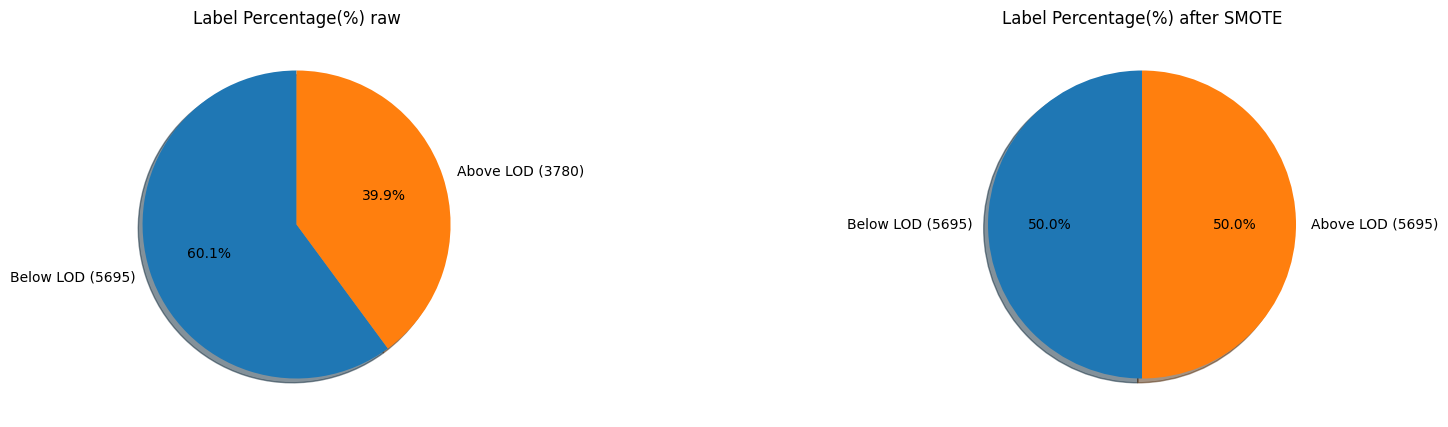

In [16]:
from imblearn.over_sampling import SMOTE
over_sample = SMOTE()
X_TRAIN_SMOTE, Y_TRAIN_SMOTE = over_sample.fit_resample(X_TRAIN, Y_TRAIN)

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

y_train_smote = np.unique(Y_TRAIN_SMOTE, return_counts = True)
y_train_raw = np.unique(Y_TRAIN, return_counts = True)

axes[0].pie(y_train_raw[1], labels=[f'Below LOD ({y_train_raw[1][0]})', f'Above LOD ({y_train_raw[1][1]})'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Label Percentage(%) raw')

axes[1].pie(y_train_smote[1], labels=[f'Below LOD ({y_train_smote[1][0]})', f'Above LOD ({y_train_smote[1][1]})'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].set_title('Label Percentage(%) after SMOTE')

Chia dữ liệu TEST (không dùng SMOTE)

In [17]:
X_TEST = df_test.iloc[:,-N_WAVELENGTH:]
Y_TEST = np.where(df_test[NAME_COLUMNS_HISTAMINE] >= LOD_HISTAMINE, 1, 0)
y_test_raw = np.unique(Y_TEST, return_counts = True)

y_test_raw


(array([0]), array([4279], dtype=int64))

# Tiền xử lý

Savizky-Golay 

In [18]:
def my_SG(X, deriv=0):
    return savgol_filter(X, window_length=25, polyorder=5, deriv=deriv)

In [19]:
def snv(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        temp_mean = temp_nir.mean()
        temp_std = temp_nir.std(ddof=0)
        df_output.iloc[i,-N_WAVELENGTH:] = (df_output.iloc[i,-N_WAVELENGTH:] - temp_mean) / temp_std
    return df_output

def msc(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    df_input = (df_input.T - np.mean(df_input.T, axis=0)).T
    ref = np.mean(df_input, axis=0)

    for i in range(df_input.shape[0]):
        # Run regression
        fit = np.polyfit(ref, df_input.iloc[i,:], 1, full=True)
        # Apply correction
        df_output.iloc[i,-N_WAVELENGTH:] = (df_input.iloc[i,:] - fit[0][1]) / fit[0][0] 
    return df_output

def my_MinMaxScaler(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        x_min = min(df_output.iloc[i,-N_WAVELENGTH:])
        x_max = max(df_output.iloc[i,-N_WAVELENGTH:])
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - x_min) / (x_max - x_min)
    return df_output

def my_RobustScaler(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        Q1 = np.percentile(temp_nir, 25)
        median = np.percentile(temp_nir, 50)
        Q3 = np.percentile(temp_nir, 75)
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - median) / (Q3 - Q1)
    return df_output


In [20]:
def my_preprocess_data(X_data, feature='sg0', normalization = 'msc'):
    X_data_prep = X_data

    if normalization == 'msc':
        X_data_prep = msc(X_data)
    elif normalization == 'snv':
        X_data_prep = snv(X_data)
    elif normalization == 'minmax':
        X_data_prep = my_MinMaxScaler(X_data)
    elif normalization == 'robust':
        X_data_prep = my_RobustScaler(X_data)
        
    if feature == 'sg0':
        X_data_prep = my_SG(X_data_prep, 0)
    elif feature == 'sg1':
        X_data_prep = my_SG(X_data_prep, 1)
    elif feature == 'sg2':
        X_data_prep = my_SG(X_data_prep, 2)
    elif feature == 'sg1 + sg2':
        X_data_SG1 = my_SG(X_data_prep, 1)
        X_data_SG2 = my_SG(X_data_prep, 2)
        X_data_prep = np.hstack([X_data_SG1, X_data_SG2])
        
    return X_data_prep

# chọn các đặt trưng tối ưu

In [21]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def get_optimal_wavelength(X, y, top_n_features=10):
    best_features = SelectKBest(score_func=f_classif, k=top_n_features)
    fit = best_features.fit(X, y)

    return list(fit.get_feature_names_out())

In [22]:
# dữ liệu train và test đã dùng SMOTE
X_DATA = pd.concat([X_TRAIN_SMOTE, X_TEST], axis=0)
Y_DATA = np.hstack((Y_TRAIN_SMOTE, Y_TEST))

In [23]:
def get_list_wl_for_data_preprocessed(x_data, y_data):
    result = []
    
    length_wl = x_data.shape[1]
    start = int(length_wl*0.2)
    step = int(length_wl*0.1)
    
    for n_wl in range(start, length_wl, step):
        n_wavelength = get_optimal_wavelength(x_data, y_data, n_wl)
        n_wavelength = [int(re.findall(r'\d+', i)[0]) for i in n_wavelength]
        result.append(n_wavelength)
    return result

In [24]:
def get_list_wl(x_data, y_data):
    result = []
    
    length_wl = x_data.shape[1]
    start = int(length_wl*0.2)
    step = int(length_wl*0.1)
    
    for n_wl in range(start, length_wl, step):
        n_wavelength = get_optimal_wavelength(x_data, y_data, n_wl)
        n_wavelength = [int(i) - 1 for i in n_wavelength]
        result.append(n_wavelength)
    return result

# SVM

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [26]:
best_acc_svm = 0
best_c = 0
best_kernel = ''

for kernel in ['linear', 'rbf']:
    for c in range(-3,4):
        svc = SVC(kernel=kernel, C=10**int(c)) 
        svc.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
        y_pred = svc.predict(X_TEST)
        acc = accuracy_score(Y_TEST, y_pred)
        
        if acc > best_acc_svm:
            best_acc_svm = acc
            best_c = 10**int(c)
            best_kernel = kernel

In [27]:
print(f'kernel: {best_kernel}, C: {best_c} => accuracy: {best_acc_svm}')

kernel: linear, C: 100 => accuracy: 0.910025706940874


In [28]:
def my_SVM(X_train, y_train, X_test, y_test):

    svc = SVC(kernel=best_kernel, C=best_c) 
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred),5)*100

    return acc

In [38]:
test_max_acc = 0
test_wl_optimal_svm = []
for n_wavelength in get_list_wl(X_DATA, Y_DATA):
    acc = my_SVM(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE, X_TEST.iloc[:,n_wavelength], Y_TEST)
    if acc > test_max_acc:
        test_max_acc = acc
        test_wl_optimal_svm = n_wavelength
print(test_max_acc, len(test_wl_optimal_svm))

93.176 67


In [39]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']


acc_svm0 = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train = my_preprocess_data(X_TRAIN_SMOTE.iloc[:,test_wl_optimal_svm],  feature=feature, normalization=normal)
        X_test = my_preprocess_data(X_TEST.iloc[:,test_wl_optimal_svm], feature=feature, normalization=normal)
        
        acc = my_SVM(X_train, Y_TRAIN_SMOTE, X_test, Y_TEST)

        print(acc)
        acc_svm0.append(acc)


100.0
88.33800000000001
84.342
70.624
38.724
92.194
87.1
76.256
0.8410000000000001
83.968
28.768
59.733999999999995
38.911
92.265
87.40400000000001
75.649


In [29]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

list_wl_optimal_svm = []
acc_svm = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train = my_preprocess_data(X_TRAIN_SMOTE,feature=feature, normalization=normal)
        X_test = my_preprocess_data(X_TEST,feature=feature, normalization=normal)
        
        max_acc = 0
        wl_optimal_svm = []
        for n_wavelength in get_list_wl_for_data_preprocessed(np.vstack((X_train, X_test)), np.hstack((Y_TRAIN_SMOTE, Y_TEST))):
            acc = my_SVM(X_train[:,n_wavelength], Y_TRAIN_SMOTE, X_test[:,n_wavelength], Y_TEST)
            if acc > max_acc:
                max_acc = acc
                wl_optimal_svm = n_wavelength
 
        print(max_acc, len(wl_optimal_svm))
        acc_svm.append(max_acc)
        list_wl_optimal_svm.append(wl_optimal_svm)

100.0 221
90.979 89
94.228 67
90.301 89
72.003 111
87.1 45
82.82300000000001 111
89.34299999999999 45
40.5 221
80.907 133
94.718 221
70.811 133
68.03 226
85.861 91
82.23899999999999 226
87.497 91


In [40]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

acc_svm2 = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train = my_preprocess_data(X_TRAIN_SMOTE,feature=feature, normalization=normal)
        X_test = my_preprocess_data(X_TEST,feature=feature, normalization=normal)
        
        max_acc = 0
        wl_optimal_svm = []
        acc = my_SVM(X_train, Y_TRAIN_SMOTE, X_test, Y_TEST)
 
        print(acc)
        acc_svm2.append(acc)

100.0
79.364
84.319
78.89699999999999
60.738
78.102
80.837
76.23299999999999
40.874
75.111
95.069
69.64200000000001
61.159
77.822
80.60300000000001
76.093


In [30]:
X_train = my_preprocess_data(X_TRAIN_SMOTE,feature='sg0', normalization='msc')
X_test = my_preprocess_data(X_TEST,feature='sg0', normalization='msc')

svc = SVC(kernel=best_kernel, C=best_c) 
svc.fit(X_train[:,list_wl_optimal_svm[0]], Y_TRAIN_SMOTE)
y_pred = svc.predict(X_test[:,list_wl_optimal_svm[0]])
acc = np.round(accuracy_score(Y_TEST, y_pred),5)*100
confuse_matrix = metrics.confusion_matrix(Y_TEST, y_pred)
print(acc)
print(confuse_matrix)

100.0
[[4279]]
